In [623]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 9, 5

## Реалізація МНКО

In [624]:
def RMNK(X, y, s=None, sigma_estimation=None, verbose=False,
         deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            if sigma_estimation is None:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
            else:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp_simple',
                                           'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        Cp_simple = RSS_next + 2 * m
        if sigma_estimation is None:
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp': Cp_simple, 'FPE': FPE},
                           ignore_index=True)
        else:
            Cp = RSS_next + 2 * sigma_estimation * m
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp_simple': Cp_simple,
                            'Cp': Cp, 'FPE': FPE},
                           ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

# Пошук моделі оптимальної складності

In [625]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.3
    s0 = 3
    s = m
    
    def __init__(self, m=None, s0=None, theta=None, a=None, b=None,
                 X=None, y=None):
        if m:
            self.m = m
            self.s = m
        if s0:
            self.s0 = s0
        if theta:
            if isinstance(theta, dict) and theta['random']:
                self.theta = np.zeros(self.m)
                self.theta[:self.s0] = np.random.uniform(*theta['random'],
                                                         size=self.s0)
            elif theta == 'unknown':
                assert X is not None, 'Please provide data (X)'
                assert y is not None, 'Please provide target values as well (y)'
                self.theta = theta
            else:
                self.theta = theta
        if a:
            self.a = a
        if b:
            self.b = b
        if X is not None:
            assert y is not None, 'Please provide target values as well (y)'
            self.X = np.array(X)
            self.y = np.array(y)
            (self.n, self.m) = X.shape
            self.s = self.m
        else:
            self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self, n=None, sigma=None):
        if n:
            self.n = n
        if sigma:
            self.sigma = sigma
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def show(self, n_limit=10):
        print('Regressors: m = {}'.format(self.m))
        print('True parameters: θ = {}'.format(self.theta))
        if not isinstance(self.theta, str):
            equation_str = ''
            for i, theta_i in enumerate(self.theta):
                equation_str += ' + ({}) * x{}'.format(theta_i, i+1)
            equation_str = 'y0 = '+ equation_str[3:]
            print(equation_str)
            print('Noise generation: σ = {}'.format(self.sigma))
        print('Sample length: n = {}'.format(self.n))
        print('X[:10]:\n{}'.format(self.X[:n_limit]))
        print('y[:10]:\n{}'.format(self.y[:n_limit]))
        
    def show_estimations(self):
        print('RSS(m) = {:5.5}'.format(self.RSS))
        print('σ* = {:5.5}'.format(self.sigma_hat ** .2))
    
    def estimate_sigma(self):
        _, _, self.RSS = RMNK(self.X, self.y, s=self.s,
                         verbose=False, create_dataframe=False)
        self.sigma_hat = self.RSS ** 2 / (self.X.shape[0] - self.X.shape[1])
        
    def run_grid_RMNK_model_selection(self):
        self.estimate_sigma()
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.compile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = RMNK(self.X, self.y, s=self.s,
                                            verbose=True, create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_RMNK_model_selection(self, p=None, plot=False, 
                                        criteria=['Cp', 'FPE', 'RSS']):
        """Single RMNK
        
        p : str in ['direct', 'reverse', 'correlation'] or list
            if list: permutation indices
            if str: how to create permutation
        """
        if p == 'reverse':
            print('=============\nREVERSE\n=============')
            p = np.flip(np.arange(self.m), axis=0)
        elif p == 'correlation':
            print('=====================\nCORRELATION INCLUDING\n=====================')
            correlations = np.abs(np.cov(self.X.T, self.y.T)[-1,:-1])
            p = np.argsort(-correlations)
        elif isinstance(p, list):
            print('=============\nCUSTOM\n=============')
        else:
            print('=============\nDIRECT\n=============')
            p = np.arange(self.m)
        print('Regressors order: {}'.format(p))
        theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                    verbose=False, create_dataframe=True)
            
        df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
        for criterion in criteria:
            df[criterion] = np.round(df[criterion], 6)
        if plot:
            for criterion in criteria:
                plt.plot(df['s'], df[criterion], label=criterion)
                plt.legend()
                plt.show()
        df = df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        self.s_opt, self.regressors_opt = df.loc[0, ['s','regressors']]
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return df
    
    def run_single_full_RMNK_model_selection(self,
                                             criteria=['Cp', 'FPE', 'RSS']):
        print('=============\nBRUT FORCE\n=============')
        total_df = pd.DataFrame()
        for p in permutations(range(self.m)):
            p = np.array(p)
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        return total_df
    
    def run_single_random_RMNK_model_selection(self, K=20,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nRANDOM INCLUDING WITH K = {}\n================================'.format(K))
        permutations = [np.random.permutation(self.m) for k in range(K)]
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        for p in permutations:
            p = np.array(p)
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=criteria).reset_index()
            main_criterion_value = df.loc[0, main_criterion]
            if main_criterion_value < self.main_criterion_value:
                self.main_criterion_value = main_criterion_value
                self.theta_pred = theta_pred
                self.s_opt, self.regressors_opt = df.loc[0,
                                                         ['s', 'regressors']]
            total_df = pd.concat([total_df, df], axis=0)
            best_df = pd.concat([best_df, df.loc[0:0]], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print()
        print(best_df[:5])
        print('...')
        print(best_df[-5:])
        print()
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df
    
    def run_single_picking_RMNK_model_selection(self,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nPICKING INCLUDING\n================================'.format(K))
        self.regressors_opt = []
        left_indices = list(np.range(self.m)
        permutations = [regressors_indices + [i] for i in left_indices]
        self.main_criterion_value = np.Inf
        for p in permutations:
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=len(p),
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=criteria).reset_index()
            main_criterion_value = df.loc[0, main_criterion]
            if main_criterion_value < self.main_criterion_value:
                self.main_criterion_value = main_criterion_value
                self.theta_pred = theta_pred
                self.s_opt, self.regressors_opt = df.loc[0,
                                                         ['s', 'regressors']]
            total_df = pd.concat([total_df, df], axis=0)
            best_df = pd.concat([best_df, df.loc[0:0]], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print()
        print(best_df[:5])
        print('...')
        print(best_df[-5:])
        print()
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        return total_df, best_df
    

## Задання конфігурацій. Створення вибірок

### Тест 1 (вибірка аналогічна вибірці з лабораторної роботи №2)

In [626]:
config1 = ModelConfig(a=0, b=0.5)
config1.compile(n=1000)
config1.generate_noise_and_output()
config1.show()

Regressors: m = 5
True parameters: θ = [ 3 -2  1  0  0]
y0 = (3) * x1 + (-2) * x2 + (1) * x3 + (0) * x4 + (0) * x5
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.03681244 0.2328146  0.022194   0.49286089 0.26525601]
 [0.19670304 0.20897471 0.19834191 0.3775959  0.08990125]
 [0.48389836 0.44521889 0.0086247  0.49518199 0.35764481]
 [0.2780668  0.2656907  0.15567972 0.15321773 0.309037  ]
 [0.16709806 0.01145448 0.29360321 0.13088148 0.17618804]
 [0.43898293 0.27150413 0.14091688 0.36047379 0.23309455]
 [0.27736848 0.2139179  0.18690541 0.22335776 0.19653261]
 [0.32496836 0.36885358 0.36793231 0.23666946 0.41841507]
 [0.43549546 0.19133817 0.47225474 0.37535722 0.29790832]
 [0.35501469 0.11570359 0.2003423  0.14256618 0.23380121]]
y[:10]:
[-0.63986665  0.18612406  0.1065405   0.35810936  0.88868648  1.13693586
  0.85395978  0.85095252  1.20948959  0.82419922]


### Тест 2 (велика вибірка з великою кількістю регресорів)

In [681]:
config2 = ModelConfig(m=15, s0=10, a=0, b=0.5, theta={'random': [1, 10]})
config2.compile(n=1000)
config2.generate_noise_and_output()
config2.show(5)

Regressors: m = 15
True parameters: θ = [5.97210317 4.86107574 5.82450262 3.55040437 3.86459627 5.04937404
 6.61378967 8.28391115 1.46023858 5.99707121 0.         0.
 0.         0.         0.        ]
y0 = (5.972103171646234) * x1 + (4.861075743189338) * x2 + (5.824502615587379) * x3 + (3.5504043675808297) * x4 + (3.864596272495195) * x5 + (5.049374037749504) * x6 + (6.613789674183755) * x7 + (8.283911151053491) * x8 + (1.4602385750421958) * x9 + (5.997071207883257) * x10 + (0.0) * x11 + (0.0) * x12 + (0.0) * x13 + (0.0) * x14 + (0.0) * x15
Noise generation: σ = 0.3
Sample length: n = 1000
X[:10]:
[[0.12897796 0.41595819 0.42456359 0.21303093 0.32340781 0.39024948
  0.12273252 0.23240344 0.41411046 0.2144005  0.40322462 0.02781469
  0.1826461  0.13011081 0.44284339]
 [0.02959981 0.06779383 0.02733201 0.30499447 0.11893972 0.35455782
  0.06434137 0.31312804 0.49016415 0.117884   0.04177466 0.34820999
  0.23032235 0.36007021 0.11463227]
 [0.13626896 0.0962296  0.19759231 0.32017878 0.443

### Тест 3 (власні задачі)

#### Діабет

Для 442 пацієнтів з діабетом, маємо 10 вхідних змінних:
- вік
- стать
- індекс маси тіла
- середній артеріальний тиск
- шість вимірів сироватки крові,

Вихідна змінна:
- кількісний показник прогресії хвороби через рік після вимірювання.

В кожному з цих 10 регресорів елементи відцентровані та поділені на $n \sigma$ (тобто в кожному стовпці сума квадратів елементів становить 1).

In [636]:
# dataframe_path = 'data/diabetes.csv'
# df = pd.read_csv(dataframe_path)
# config3 = ModelConfig(theta='unknown',
#                       X=df.loc[:, 'age':'s6'],
#                       y=df['target'])
# config3.show(5)

#### Оцінка смертності


In [642]:
dataframe_path = 'data/death-rate.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'A1':'A15'],
                      y=df['B'])
config3.X = np.hstack((config3.X, np.ones((config3.n, 1))))
config3.m += 1
config3.s += 1
config3.show(2)

Regressors: m = 16
True parameters: θ = unknown
Sample length: n = 60
X[:10]:
[[3.600e+01 2.700e+01 7.100e+01 8.100e+00 3.340e+00 1.140e+01 8.150e+01
  3.243e+03 8.800e+00 4.260e+01 1.170e+01 2.100e+01 1.500e+01 5.900e+01
  5.900e+01 1.000e+00]
 [3.500e+01 2.300e+01 7.200e+01 1.110e+01 3.140e+00 1.100e+01 7.880e+01
  4.281e+03 3.600e+00 5.070e+01 1.440e+01 8.000e+00 1.000e+01 3.900e+01
  5.700e+01 1.000e+00]]
y[:10]:
[921.87  997.875]


#### Октан

При дослідженні виробничого процесу нафтопереробному заводі вимірюється вміст октану в певного бензині залежно від кількості 3-х сировинних матеріалів та змінної, що характеризує умови виробництва. Вхідні змінні (5):
- одиниця, відповідає вільному члену
- кількість матеріалу 1
- кількість матеріалу 2
- кількість матеріалу 3
- кількісний показник умов виробництва

Вихідна змінна:
- вміст октану

In [646]:
dataframe_path = 'data/octane-rating.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'One':'Condition'],
                      y=df['Octane number'])
config3.show(5)

Regressors: m = 5
True parameters: θ = unknown
Sample length: n = 82
X[:10]:
[[ 1.      55.33     1.72    54.       1.66219]
 [ 1.      59.13     1.2     53.       1.58399]
 [ 1.      57.39     1.42    55.       1.61731]
 [ 1.      56.43     1.78    55.       1.66228]
 [ 1.      55.98     1.58    54.       1.63195]]
y[:10]:
[92.19 92.74 91.88 92.8  92.56]


#### House Prices

Прогнозування цін на нерухомість.

! TODO: DESCRIBE TASK

Вхідні змінні:
- .

Вихідна змінна:
- .

In [682]:
dataframe_path = 'data/house-prices-cleaned.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'MSSubClass':'YrSold'],
                      y=df['SalePrice'])
config3.show(1)

Regressors: m = 36
True parameters: θ = unknown
Sample length: n = 1460
X[:10]:
[[4.11087386e+00 4.18965474e+00 9.04204006e+00 7.00000000e+00
  5.00000000e+00 2.00300000e+03 2.00300000e+03 5.28320373e+00
  6.56103067e+00 0.00000000e+00 5.01727984e+00 6.75343792e+00
  6.75343792e+00 6.75110147e+00 0.00000000e+00 7.44483327e+00
  1.00000000e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
  3.00000000e+00 6.93147181e-01 8.00000000e+00 0.00000000e+00
  2.00300000e+03 2.00000000e+00 5.48000000e+02 0.00000000e+00
  4.12713439e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.00000000e+00 2.00800000e+03]]
y[:10]:
[12.24769912]


## Пошук моделі. Послідовне включення (метод з лабораторної роботи №2)

DIRECT
Regressors order: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


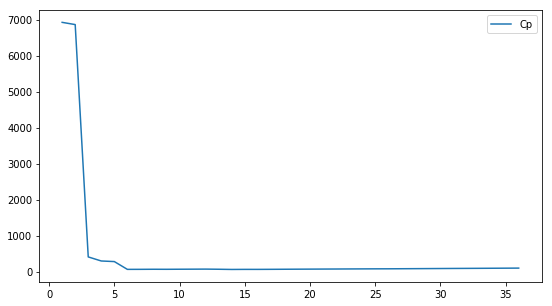

Optimal:
	s* = 14.0
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

REVERSE
Regressors order: [35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12
 11 10  9  8  7  6  5  4  3  2  1  0]


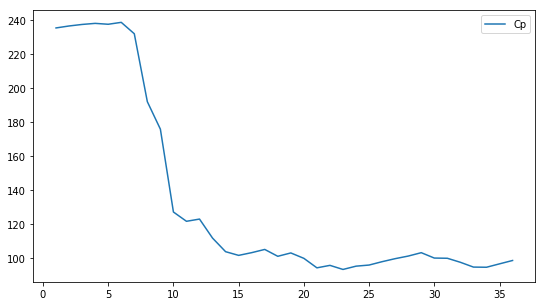

Optimal:
	s* = 23.0
	regressors = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [678]:
df1 = config3.run_single_RMNK_model_selection(p=None,
                                       criteria=['Cp'],
                                       plot=True)
print()
df2 = config3.run_single_RMNK_model_selection(p='reverse',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод кореляційного включення

CORRELATION INCLUDING
Regressors order: [26 24  5  1  6  7  3 28 27 22  8 13 25 11 10 29 18 23 15  2 12 20 19 34
 31 16 33  9 35  4 14 30 32  0 21 17]


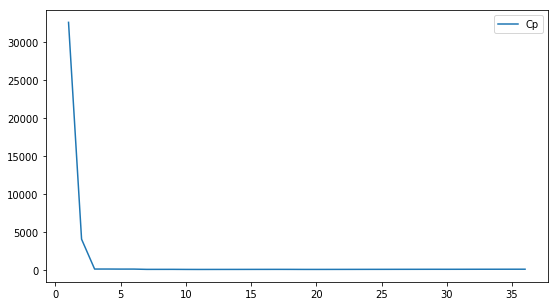

Optimal:
	s* = 11.0
	regressors = [2, 4, 6, 7, 8, 9, 23, 25, 27, 28, 29]


In [679]:
df1 = config3.run_single_RMNK_model_selection(p='correlation',
                                       criteria=['Cp'],
                                       plot=True)

## Пошук моделі. Метод випадкового включення

In [680]:
Ks = [10, 20, 50, 100]
for K in Ks:
    config3.run_single_random_RMNK_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

     s*                                        regressors*         Cp
0  22.0  [2, 3, 5, 6, 8, 10, 11, 13, 14, 17, 19, 20, 21...  80.724651
1  21.0  [5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 2...  81.625466
2  15.0  [4, 9, 11, 12, 14, 16, 18, 19, 24, 26, 28, 30,...  67.867975
3  22.0  [1, 2, 3, 5, 6, 8, 11, 13, 14, 15, 18, 20, 22,...  84.321065
4  13.0  [5, 6, 9, 10, 15, 16, 17, 18, 22, 26, 28, 31, 35]  68.384456
...
     s*                                        regressors*         Cp
5  15.0  [1, 2, 4, 6, 9, 10, 11, 15, 16, 19, 20, 27, 31...  68.050059
6   8.0                     [2, 6, 13, 14, 15, 17, 20, 27]  72.605223
7  28.0  [2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 18, ...  83.978672
8  21.0  [2, 4, 6, 7, 8, 9, 11, 13, 14, 19, 20, 23, 25,...  77.336096
9   8.0                      [4, 6, 8, 13, 21, 26, 29, 36]  64.000055

Optimal:
	s* = 8.0
	regressors = [4, 6, 8, 13, 21, 26, 29, 36]
RANDOM INCLUDING WITH K = 20

     s*                         

## Пошук моделі. Метод перебірного включення